In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.axes import Axes
import pandas as pd

from stoneforge.preprocessing import las_import

In [2]:
data,units = las_import("..//stoneforge//datasets/DP1.las")
data

,DEPT,SP,ILD,ILM,LL8,GR,CALI,DRHO,RHOB,NPHI,DT
0,100.0,-999.0,-999.0,-999.0,-999.0,25.1383,-999.0,-999.0,-999.0,-999.0,-999.0
1,100.5,-999.0,-999.0,-999.0,-999.0,24.7342,-999.0,-999.0,-999.0,-999.0,-999.0
2,101.0,-999.0,-999.0,-999.0,-999.0,24.9611,-999.0,-999.0,-999.0,-999.0,-999.0
3,101.5,-999.0,-999.0,-999.0,-999.0,25.1880,-999.0,-999.0,-999.0,-999.0,-999.0
4,102.0,-999.0,-999.0,-999.0,-999.0,25.4148,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...
15688,7944.0,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0,-999.0,-999.0,-999.0,-999.0
15689,7944.5,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0,-999.0,-999.0,-999.0,-999.0
15690,7945.0,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0,-999.0,-999.0,-999.0,-999.0
15691,7945.5,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0,-999.0,-999.0,-999.0,-999.0


In [3]:
print(units)

{'DEPT': 'F', 'SP': 'MV', 'ILD': 'OHMM', 'ILM': 'OHMM', 'LL8': 'OHMM', 'GR': 'GAPI', 'CALI': 'IN', 'DRHO': 'G/C3', 'RHOB': 'G/C3', 'NPHI': '%', 'DT': 'US/F'}


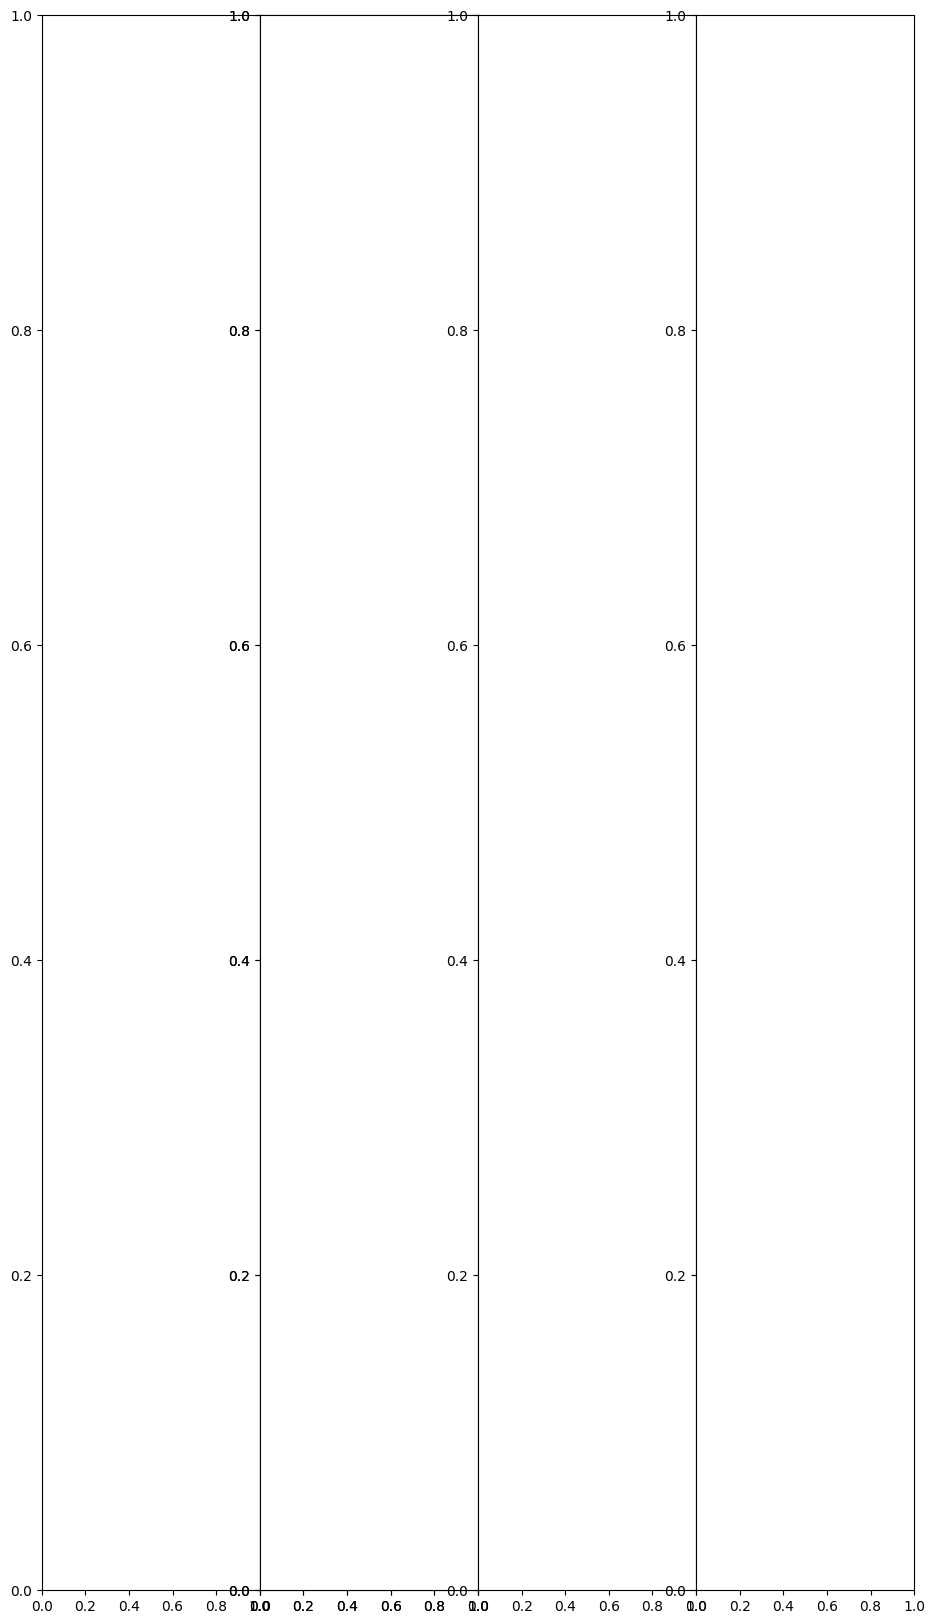

In [4]:
CM = 0.3937  # centimeters in inches
fig = plt.figure(figsize=(27.7*CM, 40*CM))

ax1 = fig.add_axes([0.1, 0.1, 0.2, 1.0])
ax2 = fig.add_axes([0.3, 0.1, 0.2, 1.0])
ax3 = fig.add_axes([0.3, 0.1, 0.2, 1.0])
ax4 = fig.add_axes([0.5, 0.1, 0.2, 1.0])
ax5 = fig.add_axes([0.7, 0.1, 0.2, 1.0])

plt.show()

In [119]:
class LogPlot:

    def __init__(self, size=(27.7, 40.0)):
        self.cm = 0.3937
        self.fig = plt.figure(figsize=(size[0]*self.cm, size[1]*self.cm))
        
        self.ax = None
        self.xzeros = []
        self.yzeros = []
        self.widths = []
        self.heights = []
        self._first_track = True

        self._subs = 0
        self._bar = (1+int(0.9167 * size[0] + 0.833))*'─'

        self.y = None
        self.depth_description = "Depth"
        self.top = None
        self.bot = None

    def _format_bar(self, min_val, max_val, label):
        bar_str = self._bar
        total_length = len(bar_str)
        
        min_str = str(min_val)
        max_str = str(max_val)
        label_str = f" {label} "
        
        fixed_space = len(min_str) + len(max_str) + len(label_str) + 2
        remaining_space = total_length - fixed_space
        
        if remaining_space < 0:
            raise ValueError("Bar is too short to fit min, max, and label")
        
        left_dashes = remaining_space // 2
        right_dashes = remaining_space - left_dashes
        
        new_bar = (
            f"{min_str} " +
            "─" * left_dashes +
            label_str +
            "─" * right_dashes +
            f" {max_str}"
        )
        
        return new_bar

    def _addtrack(self, w=0.2, pos=False):
        if self.xzeros:
            if pos:
                self.xzeros.append(self.xzeros[-1])
                self._subs += 1
            else:
                self.xzeros.append(self.xzeros[-1] + self.widths[-1])
                self._subs = 0
        else:
            self.xzeros.append(0.1)

        self.yzeros.append(0.1)
        self.widths.append(w)
        self.heights.append(1.0)
        
        self.ax = self.fig.add_axes([self.xzeros[-1], self.yzeros[-1], self.widths[-1], self.heights[-1]])
        self.ax.patch.set_alpha(0)
        
        if not self._first_track:
            self.ax.set_yticklabels([])
        else:
            self.ax.set_ylabel(self.depth_description)
        
        self._first_track = False

    def set_depth(self, y, d, top=None, bot=None):
        self.y = y
        self.depth_description = d
        
        if top == None:
            self.top = np.nanmin(y)
        else:
            self.top = top

        if bot == None:
            self.bot = np.nanmax(y)
        else:
            self.bot = bot

    def nplot(self, x, c='black', s='-', w=0.2, pos=False, vmin=None, vmax=None, step=10, label=''):
        self._addtrack(w=w, pos=pos)
        self.ax.grid()
        if vmin == None:
            vmin = np.nanmin(x)
        if vmax == None:
            vmax = np.nanmax(x)
        _title = self._format_bar(vmin, vmax, label)
        self.ax.set_xticks(np.linspace(vmin,vmax,step+1))
        self.ax.plot(x, self.y, color=c, linestyle=s, linewidth=0.5)
        self.ax.set_xlim(vmin,vmax)
        self.ax.set_xticklabels([])
        self.ax.set_ylim(self.bot,self.top)
        self.ax.set_title(_title+'\n'*self._subs, color = c, fontsize=10)

    def lplot(self, x, c='black', s='-', w=0.2, pos=False, vmin=None, vmax=None, step=10, label=''):
        self._addtrack(w=w, pos=pos)
        if vmin == None:
            vmin = np.nanmin(x)
        if vmax == None:
            vmax = np.nanmax(x)
        _title = self._format_bar(vmin, vmax, label)
        self.ax.set_xticks(np.linspace(vmin,vmax,step+1))
        self.ax.semilogx(x, self.y, color=c, linestyle=s, linewidth=0.5)
        self.ax.set_xlim(vmin,vmax)
        self.ax.grid()
        self.ax.grid(which="minor", color="0.9")
        self.ax.set_xticklabels([])
        self.ax.set_ylim(self.bot,self.top)
        self.ax.set_title(_title+'\n'*self._subs, color = c, fontsize=10)

    def show(self):
        plt.show()

    def save(self):
        plt.savefig('image.png', bbox_inches='tight', dpi=300)

# ================================================================================================== #

#img = LogPlot()
#img._addtrack()
#img._addtrack()
#img._addtrack()
#img._addtrack()
#img._addtrack(w = 0.1)
#img._addtrack()
#img.show()

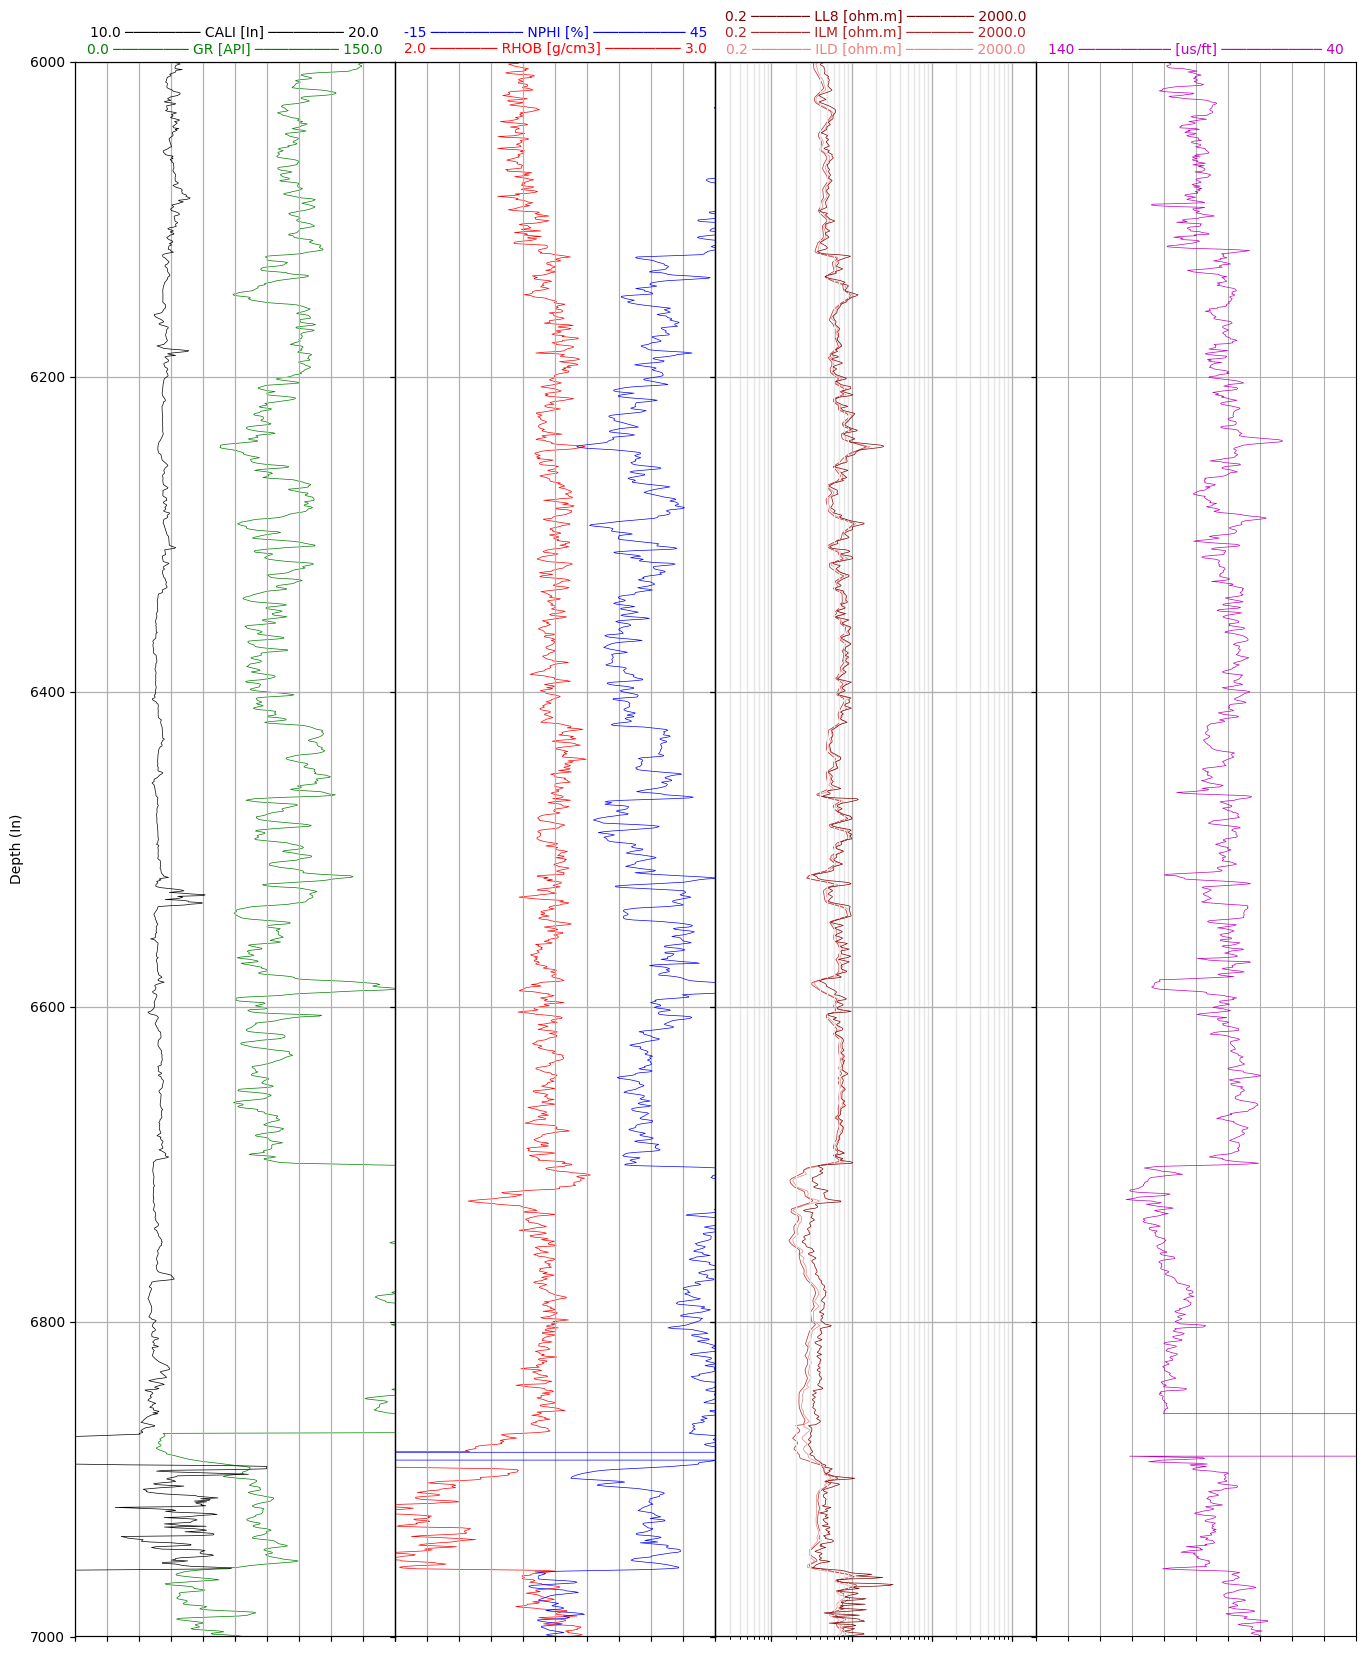

In [122]:
img = LogPlot(size=(29.7, 40.0))
img.set_depth(data['DEPT'], d="Depth (In)",top=6000,bot=7000)
img.nplot(x = data['GR'],c = 'g', vmin=0., vmax = 150., label = 'GR [API]')
img.nplot(x = data['CALI'],c = 'k', pos = True, vmin=10., vmax = 20., label = 'CALI [In]')

img.nplot(x = data['RHOB'],c = 'r', vmin=2., vmax = 3., label = 'RHOB [g/cm3]')
img.nplot(x = data['NPHI'],c = 'b', pos = True, vmin=-15, vmax=45, label = 'NPHI [%]')

img.lplot(x = data['ILD'],c = 'lightcoral', vmin=.2, vmax = 2000., label = 'ILD [ohm.m]')
img.lplot(x = data['ILM'],c = 'firebrick', pos = True, vmin=.2, vmax = 2000., label = 'ILM [ohm.m]')
img.lplot(x = data['LL8'],c = 'maroon', pos = True, vmin=.2, vmax = 2000., label = 'LL8 [ohm.m]')

img.nplot(x = data['DT'],c = 'm',vmin=140, vmax=40, label = '[us/ft]')
#img.show()
img.save()

# 5cm = 5 crt
# 10cm = 10 crt
# 15cm = 14 crt
# 20cm = 19 crt
# 25cm = 23 crt
# 30cm = 27 crt
# 40cm = 37 crt
# 50cm = 46 crt
# 60cm = 56 crt
# 70cm = 65 crt